<a href="https://colab.research.google.com/github/ChadiDridi/A-sample-of-CPA-analysis-and-K-Means-/blob/main/K_means_%2B_PCA_%2B_CAH_House_rents_in_Tunisia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importation des bibliotheques 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
%matplotlib inline
import numpy as np 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


I- Importation du Data et visulatisation 


In [ ]:
#On va utiliser une dataset tunisienne avec l exemple classique du "House Pricing" le cas d'école afin d'appliquer la méthode K-Means
# L'importation de notre DataSet
from google.colab import files
url='https://drive.google.com/file/d/1X6TgPKOX7f6G2JQTDXB3Yhzu3HHnigxR/view?usp=share_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(dwn_url)
df.head()




,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,100000.0,Ariana,Raoued,5.000000
1,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,316000.0,Ariana,Autres villes,5.499687
2,Appartements,2.0,1.0,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
3,Locations de vacances,1.0,1.0,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
4,Appartements,2.0,2.0,113.0,À Vendre,170000.0,Ariana,Ariana Ville,5.230449


Etude du data avant de faire analyse : 


In [ ]:
print(df.isnull().sum())

category          0
room_count        0
bathroom_count    0
size              0
type              0
price             0
city              0
region            0
log_price         0
dtype: int64


In [ ]:
df.info

<bound method DataFrame.info of                     category  room_count  bathroom_count   size      type  \
0         Terrains et Fermes        -1.0            -1.0   -1.0  À Vendre   
1         Terrains et Fermes        -1.0            -1.0   -1.0  À Vendre   
2               Appartements         2.0             1.0   80.0   À Louer   
3      Locations de vacances         1.0             1.0   90.0   À Louer   
4               Appartements         2.0             2.0  113.0  À Vendre   
...                      ...         ...             ...    ...       ...   
12743     Terrains et Fermes        -1.0            -1.0   -1.0  À Vendre   
12744           Appartements         1.0             1.0  100.0   À Louer   
12745      Maisons et Villas         3.0             1.0  760.0  À Vendre   
12746      Maisons et Villas         3.0             1.0  190.0  À Vendre   
12747      Maisons et Villas         2.0             1.0   70.0   À Louer   

           price    city         region  lo

In [ ]:
df.columns

Index(['category', 'room_count', 'bathroom_count', 'size', 'type', 'price',
       'city', 'region', 'log_price'],
      dtype='object')

In [ ]:
df.describe()

,room_count,bathroom_count,size,price,log_price
count,12748.000000,12748.000000,12748.000000,1.274800e+04,12748.000000
mean,1.759649,0.759884,130.896219,1.601575e+07,4.374245
std,2.171468,1.264812,184.074990,1.016644e+09,1.389788
min,-1.000000,-1.000000,-1.000000,1.000000e+01,1.000000
25%,-1.000000,-1.000000,-1.000000,8.500000e+02,2.929419
50%,2.000000,1.000000,95.000000,8.975000e+04,4.953033
75%,3.000000,1.000000,150.000000,2.600000e+05,5.414973
max,20.000000,10.000000,2000.000000,1.000000e+11,11.000000


In [ ]:
df=df[df['type']=='À Louer'] #on travaille seulement sur le data des maisons à louer (filtration des lignes)

In [ ]:
#on remplace les valeurs non exsistants par la moyenne (ici les valeurs non exsistants sont les valeurs erronnées et non pas NULL)
columns_to_check = ['room_count', 'bathroom_count', 'size']
for column in columns_to_check:
    if (df[column] < 0).sum() > 0:
        print(f"Column '{column}' has {df[column].lt(0).sum()} negative values.")

        # Replace negative values with the mean of the column
        mean_value = df[df[column] >= 0][column].mean()
        df[column] = df[column].where(df[column] >= 0, mean_value)

        print(f"Replaced negative values in '{column}' with the mean: {mean_value}")
mask = (df['price'] < 100000) & (df['price'] > 0)

# Apply the boolean mask to filter the rows that meet the condition
filtered_df = df[mask]

# Alternatively, you can use the query() method to achieve the same result
filtered_df = df.query('price < 70000 and price > 0')
df=filtered_df
df.describe()

,room_count,bathroom_count,size,price,log_price
count,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000
mean,2.400365,1.278612,143.877841,1111.598620,2.777724
std,1.276879,0.695963,163.620850,2412.734675,0.469742
min,1.000000,0.000000,20.000000,10.000000,1.000000
25%,2.000000,1.000000,77.000000,370.000000,2.568202
50%,2.000000,1.000000,100.000000,630.000000,2.799341
75%,3.000000,1.000000,150.000000,1100.000000,3.041393
max,20.000000,10.000000,2000.000000,60000.000000,4.778151


In [ ]:
'''#On code les valeurs non Numerique par OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to 'city' and 'region' columns
df['city'] = le.fit_transform(df['city'])
df['region'] = le.fit_transform(df['region'])
import pandas as pd

# Perform one-hot encoding on 'city' and 'region' columns
df = pd.get_dummies(df, columns=['city', 'region'])'''


"#On code les valeurs non Numerique par OneHotEncoder\nfrom sklearn.preprocessing import LabelEncoder\n\n# Create a LabelEncoder object\nle = LabelEncoder()\n\n# Apply label encoding to 'city' and 'region' columns\ndf['city'] = le.fit_transform(df['city'])\ndf['region'] = le.fit_transform(df['region'])\nimport pandas as pd\n\n# Perform one-hot encoding on 'city' and 'region' columns\ndf = pd.get_dummies(df, columns=['city', 'region'])"

In [ ]:
df

,category,room_count,bathroom_count,size,type,price,city,region,log_price
2,Appartements,2.0,1.0,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
3,Locations de vacances,1.0,1.0,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
5,Locations de vacances,1.0,1.0,70.0,À Louer,80.0,Ariana,Autres villes,1.903090
6,Appartements,2.0,1.0,100.0,À Louer,670.0,Ariana,Borj Louzir,2.826075
7,"Magasins, Commerces et Locaux industriels",2.0,1.0,20.0,À Louer,650.0,Ariana,Borj Louzir,2.812913
...,...,...,...,...,...,...,...,...,...
12735,Appartements,2.0,1.0,70.0,À Louer,140.0,Tunis,L'aouina,2.146128
12737,"Magasins, Commerces et Locaux industriels",1.0,1.0,300.0,À Louer,1800.0,Tunis,La Marsa,3.255273
12738,Appartements,1.0,1.0,60.0,À Louer,90.0,Tunis,L'aouina,1.954243
12744,Appartements,1.0,1.0,100.0,À Louer,600.0,Tunis,Autres villes,2.778151


In [ ]:
max_price = df['price'].max()

# Calculate the minimum value of 'price'
min_price = df['price'].min()

# Calculate the mean value of 'price'
mean_price = df['price'].mean()

print("Max Price:", max_price)
print("Min Price:", min_price)
print("Mean Price:", mean_price)

Max Price: 60000.0
Min Price: 10.0
Mean Price: 1111.5986201298701


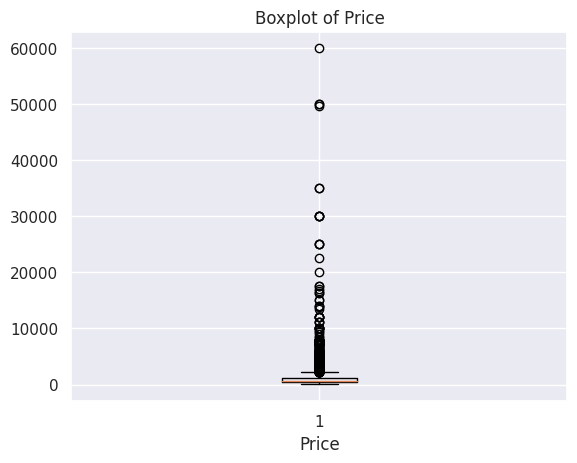

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(df['price'])
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()


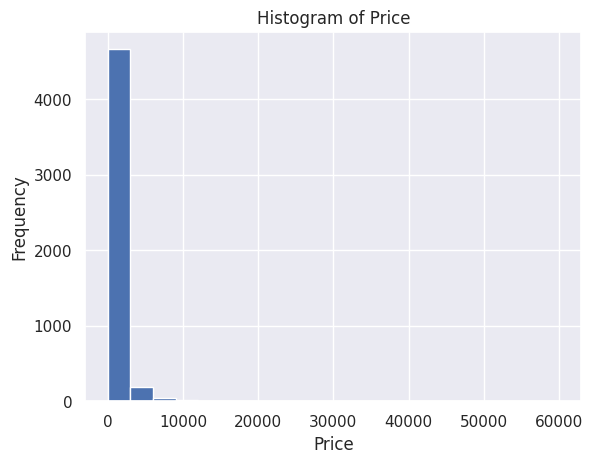

In [ ]:
# Create a histogram of the 'price' column
plt.hist(df['price'], bins=20)
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


#From these graphs we can see clearly that we have Data to remove because it ruins the analysis with its high values (we can't assume they re wrong values)

In [ ]:
# Assuming 'df' is your DataFrame
# Create a boolean mask for the condition
mask = (df['price'] < 100000) & (df['price'] > 0)
# Apply the boolean mask to filter the rows that meet the condition
filtered_df = df[mask]
# Alternatively, you can use the query() method to achieve the same result
filtered_df = df.query('price < 700000 and price > 0')
df=filtered_df
df.describe()

,room_count,bathroom_count,size,price,log_price
count,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000
mean,2.400365,1.278612,143.877841,1111.598620,2.777724
std,1.276879,0.695963,163.620850,2412.734675,0.469742
min,1.000000,0.000000,20.000000,10.000000,1.000000
25%,2.000000,1.000000,77.000000,370.000000,2.568202
50%,2.000000,1.000000,100.000000,630.000000,2.799341
75%,3.000000,1.000000,150.000000,1100.000000,3.041393
max,20.000000,10.000000,2000.000000,60000.000000,4.778151


#pour la raison d'une augmentation du dimension on ne fait pas le OneHotEncoding pour faire le PCA aprés d'une maniere efficace 

In [ ]:
df=df.drop(['type','city','region','category'],axis=1)
#pour appliquer le PCA et afin de ne pas utiliser le codage OneHotEncoding pour le data non numerique , on elimine les 4 colonnes non numeriques 
#Cette pratique est fortement contre le principe du data science et Machine Learning mais ce projet est un cas d'étude 


In [ ]:
df=df.drop(['log_price'],axis=1)
df.drop(df[df['size'] > 1000].index, inplace=True)


In [ ]:
df.shape
#on a maintenant 4 colonnes pour faire l etude de reduction et PCA (Principale Componenent analysis) 

(4892, 4)

Text(0.5, 1.0, 'Correlation between different fearures')

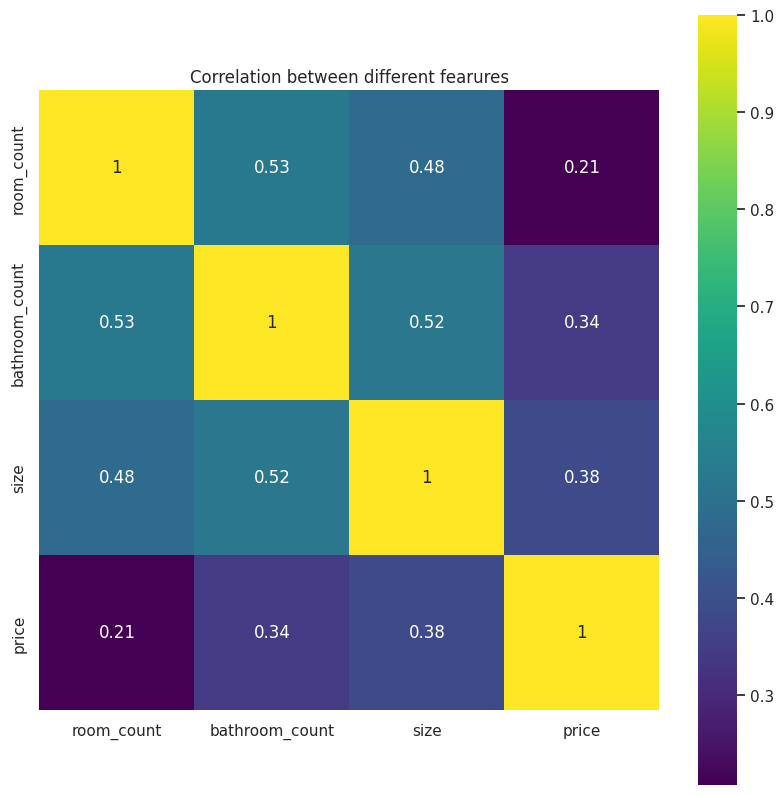

In [ ]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different fearures')


C'est la matrice de coorelation lineaire 

Maintenant on va faire une CPA pour faire le Kmeans aprés

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the data matrix
normalized_matrix = scaler.fit_transform(df)

# Create a new DataFrame from the normalized matrix
normalized_df = pd.DataFrame(data = normalized_matrix, columns = df.columns)
normalized_df.describe()

,room_count,bathroom_count,size,price
count,4.892000e+03,4.892000e+03,4.892000e+03,4.892000e+03
mean,1.074819e-16,-9.876718e-17,8.133768e-17,-1.161967e-17
std,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00
min,-1.114345e+00,-1.974708e+00,-9.770717e-01,-5.402449e-01
25%,-3.123182e-01,-4.097847e-01,-4.979031e-01,-3.477181e-01
50%,-3.123182e-01,-4.097847e-01,-2.925452e-01,-2.247149e-01
75%,4.897083e-01,-4.097847e-01,1.352839e-01,4.268337e-02
max,1.412416e+01,1.367452e+01,7.408378e+00,3.154220e+01


In [ ]:
from sklearn.decomposition import PCA
#On trace la matrice d'inertie 
pca = PCA()

# Fit the PCA to your data
pca.fit(normalized_df)
explained_variance = pca.explained_variance_

# Compute the matrix of inertia
inertia_matrix = np.diag(explained_variance)

# Print the matrix of inertia
print(inertia_matrix)

[[2.25699144 0.         0.         0.        ]
 [0.         0.8142881  0.         0.        ]
 [0.         0.         0.47996907 0.        ]
 [0.         0.         0.         0.44956922]]


In [ ]:

explained_variance_ratio = pca.explained_variance_ratio_

# Compute the contribution of each eigenvalue
eigenvalue_contributions = explained_variance_ratio * 100

# Print the eigenvalue contributions
print(eigenvalue_contributions)

[56.41325202 20.3530412  11.9967738  11.23693298]


In [ ]:

pca = PCA(n_components=3)  #c est la dim de l espace  de projection ici = 3 
pca.fit(normalized_df)
pca_samples = pca.transform(normalized_df)


In [ ]:
explained_variance = pca.explained_variance_
column_contributions = (np.square(pca.components_) * explained_variance.reshape(-1, 1)).T
# the column contributions
print(column_contributions)

[[5.68895261e-01 2.06049377e-01 4.37132737e-02]
 [6.70481710e-01 2.12863560e-02 6.58756507e-02]
 [6.60757550e-01 2.65096061e-05 3.39166888e-01]
 [3.56856923e-01 5.86925858e-01 3.12132532e-02]]


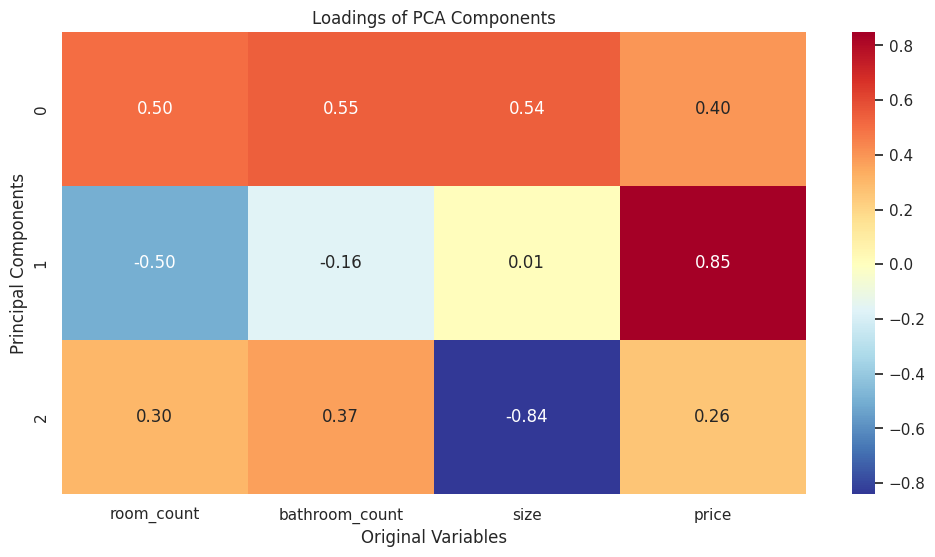

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


loadings = pca.components_

# Create a dataframe to hold the loadings
loadings_df = pd.DataFrame(loadings, columns=df.columns)

# Plot the loadings
plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, cmap='RdYlBu_r', center=0, annot=True, fmt='.2f')
plt.title('Loadings of PCA Components')
plt.xlabel('Original Variables')
plt.ylabel('Principal Components')
plt.show()


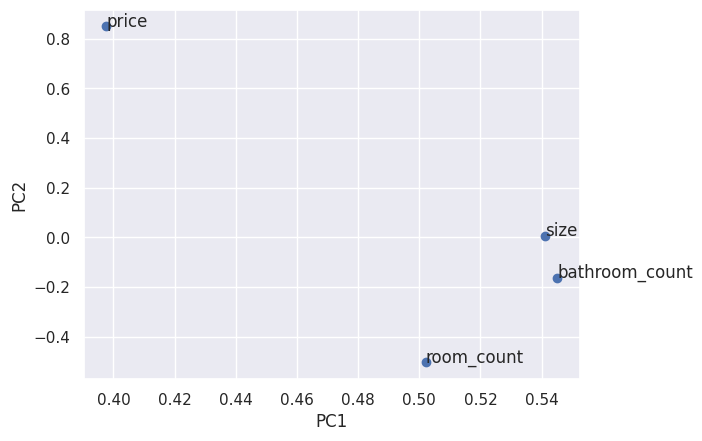

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a scatter plot of the first two principal components
plt.scatter(pca.components_[0], pca.components_[1])

# Label each point with the name of the corresponding variable
for i, variable in enumerate(df.columns):
    plt.annotate(variable, (pca.components_[0][i], pca.components_[1][i]))

# Label the x- and y-axis
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show the plot
plt.show()


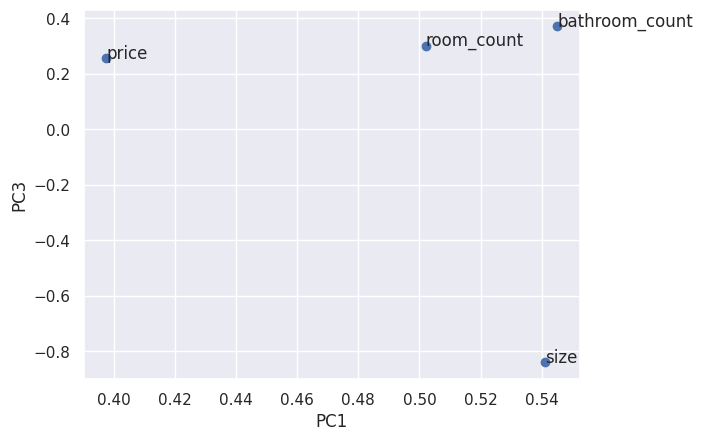

In [ ]:

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.scatter(pca.components_[0], pca.components_[2])


for i, variable in enumerate(df.columns):
    plt.annotate(variable, (pca.components_[0][i], pca.components_[2][i]))

# Label the x- and y-axis
plt.xlabel('PC1')
plt.ylabel('PC3')

# Show the plot
plt.show()


In [ ]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,-0.767171,-0.069953,0.056400
1,-1.189457,0.193229,-0.299847
2,-1.279925,0.196793,-0.154627
3,-0.612907,0.062694,-0.047907
4,-0.987539,0.049707,0.524793


In [ ]:
print(pca.components_) 


[[ 0.50205489  0.54504017  0.54107331  0.39763271]
 [-0.50303315 -0.16168198  0.00570575  0.84899001]
 [ 0.30178666  0.37047238 -0.84062074  0.25501334]]


In [ ]:
pcs_df = pd.DataFrame(data = ps, columns = ['PC1', 'PC2', 'PC3'])



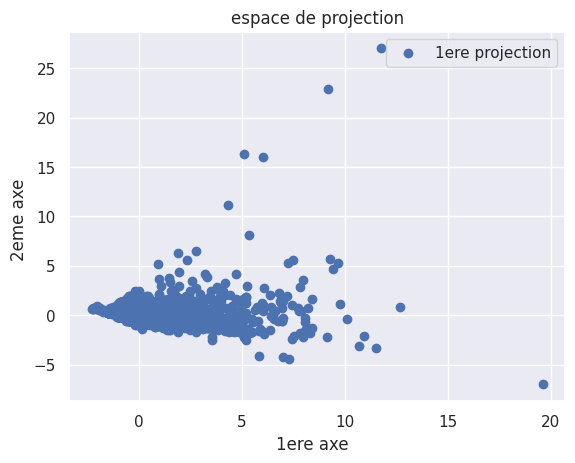

In [ ]:
plt.scatter(ps[0],ps[1], label="1ere projection", color='b')

plt.plot()

plt.xlabel("1ere axe  ")
plt.ylabel("2eme axe ")
plt.title("espace de projection")
plt.legend()
plt.show()

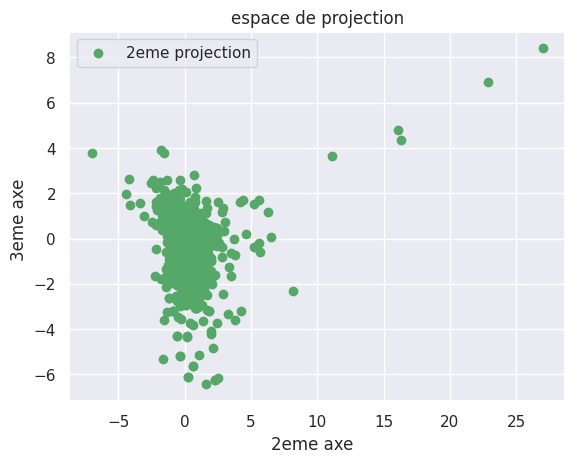

In [ ]:
plt.scatter(ps[1],ps[2], label="2eme projection", color='g')
plt.plot()

plt.xlabel("2eme axe  ")
plt.ylabel("3eme axe ")
plt.title("espace de projection")
plt.legend()
plt.show()

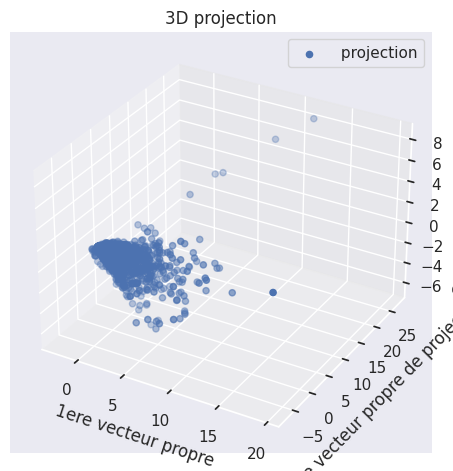

In [ ]:
#espace de projection dim = 3 en 3D: 
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(ps[0],ps[1],ps[2], label=" projection", color='b')


ax.set_xlabel('1ere vecteur propre')
ax.set_ylabel('2eme vecteur propre de projection')
ax.set_zlabel('3eme vecteur propre')
plt.title("3D projection")
plt.legend()
plt.tight_layout()
plt.show()

### Si on fait encore data cleaning et on met le limitie 20000 pour price et 150.000000 pour size (75% from the .describe() method)

In [ ]:
columns_to_check = ['room_count', 'bathroom_count', 'size']
mask = (df['price'] < 20000) & (df['size'] <150.0000000)
df = df[mask]
df.describe()

,room_count,bathroom_count,size,price
count,3648.000000,3648.000000,3648.000000,3648.000000
mean,2.079221,1.097039,88.828947,667.955592
std,0.864576,0.342433,27.917026,637.073916
min,1.000000,0.000000,20.000000,10.000000
25%,1.000000,1.000000,70.000000,350.000000
50%,2.000000,1.000000,90.000000,550.000000
75%,3.000000,1.000000,110.000000,850.000000
max,6.000000,8.000000,149.000000,13500.000000


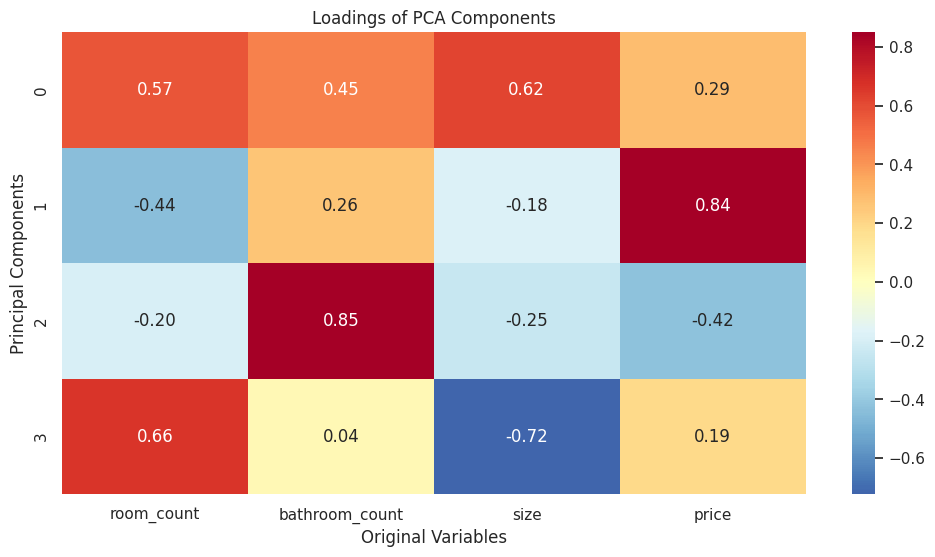

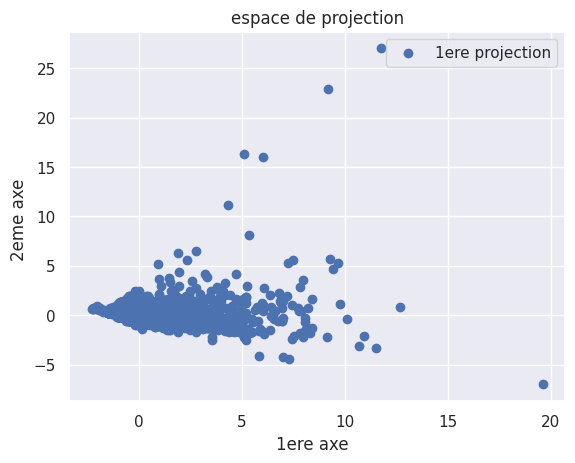

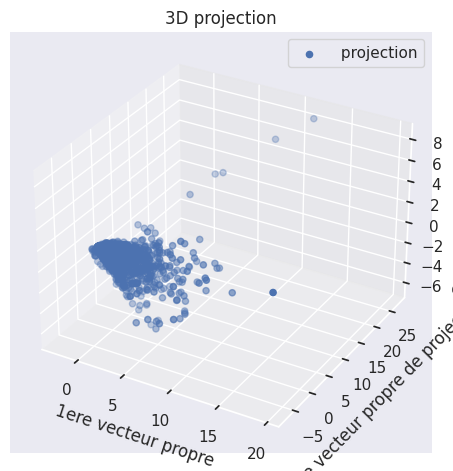

In [ ]:
normalized_matrix = scaler.fit_transform(df)
normalized_df = pd.DataFrame(data = normalized_matrix, columns =df.columns)
pca = PCA()
pca.fit(normalized_df)
explained_variance = pca.explained_variance_

inertia_matrix = np.diag(explained_variance)
loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=df.columns)

plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, cmap='RdYlBu_r', center=0, annot=True, fmt='.2f')
plt.title('Loadings of PCA Components')
plt.xlabel('Original Variables')
plt.ylabel('Principal Components')
plt.show()
explained_variance = pca.explained_variance_
column_contributions = (np.square(pca.components_) * explained_variance.reshape(-1, 1)).T
plt.scatter(ps[0],ps[1], label="1ere projection", color='b')

plt.plot()

plt.xlabel("1ere axe  ")
plt.ylabel("2eme axe ")
plt.title("espace de projection")
plt.legend()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(ps[0],ps[1],ps[2], label=" projection", color='b')


ax.set_xlabel('1ere vecteur propre')
ax.set_ylabel('2eme vecteur propre de projection')
ax.set_zlabel('3eme vecteur propre')
plt.title("3D projection")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.shape

(3648, 4)

In [ ]:
X1 = ps[[0 ,1,2]].iloc[: , :].values
inertia = []
for n in range(1 , 15):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_) #l algorithme c est entrainé 15 fois a chaque vois une novelle valeure avec le nombre de clusters = n 

In [ ]:
algorithm.fit(X1)
inertia

[17369.156954313177,
 10709.86299949785,
 8320.57328909769,
 6438.160186674577,
 5394.156543878236,
 4604.756702359855,
 4123.144690340225,
 3785.4265709392903,
 3479.746038849201,
 3200.051404170221,
 3023.0943343516938,
 2766.8604748048674,
 2599.9022745741804,
 2428.156809482188]

pour K = 2



In [ ]:
from sklearn.cluster import KMeans
algorithm = (KMeans(n_clusters = 2 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
model = algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_


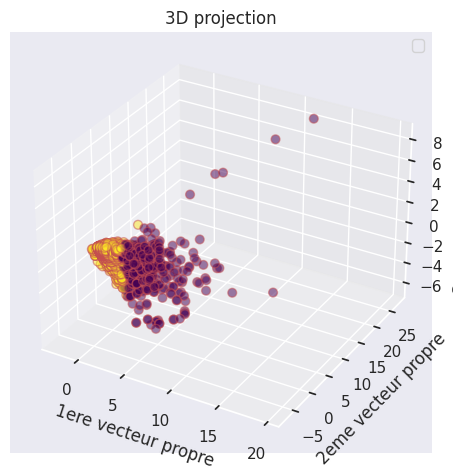

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(ps[0],ps[1],ps[2],c=algorithm.labels_, cmap='viridis',edgecolor='r', s=40, alpha = 0.5)
centroids_x = centroids1[:,0]
centroids_y = centroids1[:,1]
ax.set_xlabel('1ere vecteur propre')
ax.set_ylabel('2eme vecteur propre')
ax.set_zlabel('3eme vecteur propre')
plt.title("3D projection")
plt.legend()
plt.tight_layout()
plt.show()

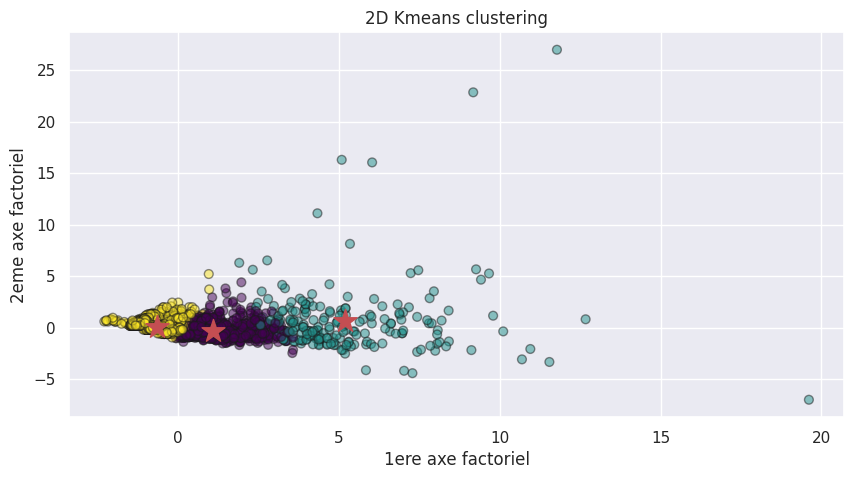

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=42)
kmeans.fit(ps)

# plot clusters and centroids
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(ps[0],ps[1], c=kmeans.labels_, cmap='viridis',
           edgecolor='k', s=40, alpha = 0.5)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
           s = 300, c = 'r', marker='*', label = 'Centroid')
ax.set_title("2D Kmeans clustering")
ax.set_xlabel("1ere axe factoriel")
ax.set_ylabel("2eme axe factoriel")   
plt.show()

Pour K=4 :

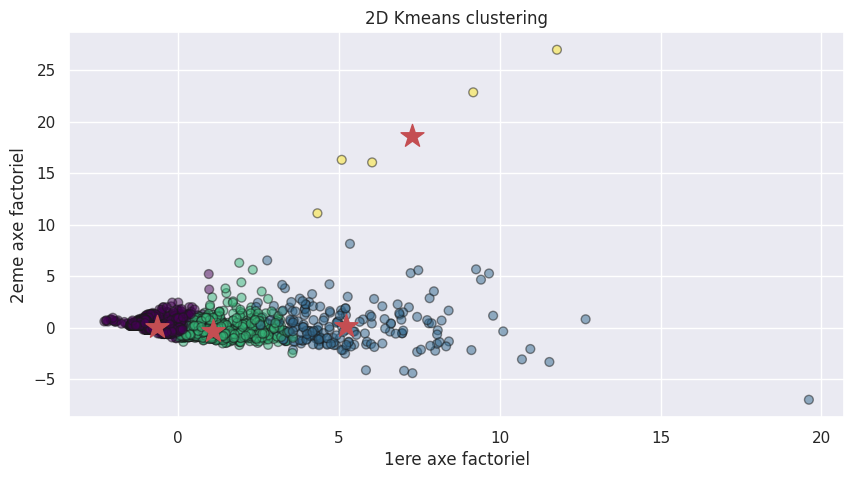

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=4, random_state=42)
kmeans.fit(ps)

# plot clusters and centroids
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(ps[0],ps[1], c=kmeans.labels_, cmap='viridis',
           edgecolor='k', s=40, alpha = 0.5)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
           s = 300, c = 'r', marker='*', label = 'Centroid')
ax.set_title("2D Kmeans clustering")
ax.set_xlabel("1ere axe factoriel")
ax.set_ylabel("2eme axe factoriel")   
plt.show()

Pour K=5

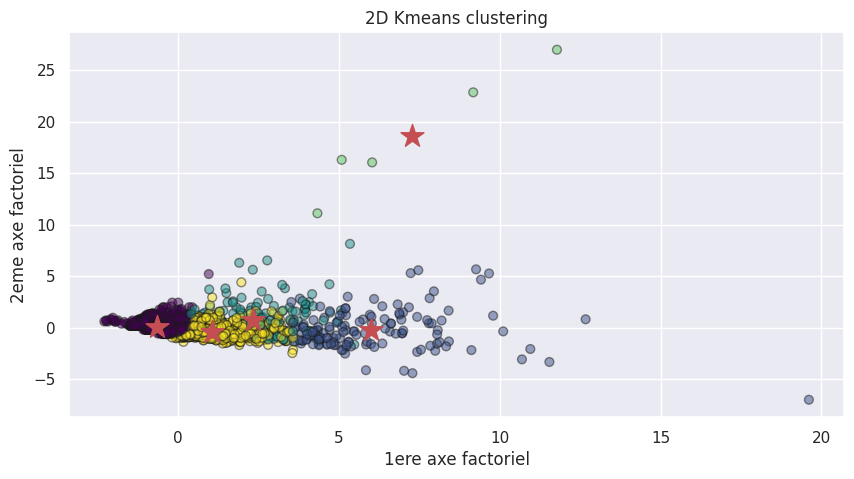

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=5, random_state=42)
kmeans.fit(ps)

# plot clusters and centroids
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(ps[0],ps[1], c=kmeans.labels_, cmap='viridis',
           edgecolor='k', s=40, alpha = 0.5)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
           s = 300, c = 'r', marker='*', label = 'Centroid')
ax.set_title("2D Kmeans clustering")
ax.set_xlabel("1ere axe factoriel")
ax.set_ylabel("2eme axe factoriel")   
plt.show()

Si on fait la Strategie  Kmeans ---> #Analyse_Hierarchique puis Kmeans sur la 1ere data maintenant 

In [ ]:
#On va utiliser une dataset tunisienne avec l exemple classique du "House Pricing" le cas d'école afin d'appliquer la méthode K-Means
# L'importation de notre DataSet
from google.colab import files
url='https://drive.google.com/file/d/1X6TgPKOX7f6G2JQTDXB3Yhzu3HHnigxR/view?usp=share_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df1= pd.read_csv(dwn_url)
df1.head()
df1=df1[df1['type']=='À Louer']
#on remplace les valeurs non exsistants par la moyenne (ici les valeurs non exsistants sont les valeurs erronnées et non pas NULL)
columns_to_check = ['room_count', 'bathroom_count', 'size']
for column in columns_to_check:
    if (df1[column] < 0).sum() > 0:
        mean_value = df1[df1[column] >= 0][column].mean()
        df1[column] = df1[column].where(df1[column] >= 0, mean_value)

# Assuming 'df' is your DataFrame
# Create a boolean mask for the condition
mask = (df1['price'] < 100000) & (df1['price'] > 0)

# Apply the boolean mask to filter the rows that meet the condition
filtered_df = df[mask]

# Alternatively, you can use the query() method to achieve the same result
filtered_df1 = df1.query('price < 70000 and price > 0')
df1=filtered_df
df1.describe()

,room_count,bathroom_count,size,price
count,3648.000000,3648.000000,3648.000000,3648.000000
mean,2.079221,1.097039,88.828947,667.955592
std,0.864576,0.342433,27.917026,637.073916
min,1.000000,0.000000,20.000000,10.000000
25%,1.000000,1.000000,70.000000,350.000000
50%,2.000000,1.000000,90.000000,550.000000
75%,3.000000,1.000000,110.000000,850.000000
max,6.000000,8.000000,149.000000,13500.000000


On remarque que meme avec une valeur max = 70000 on est encore une mauvaise figure grace au grande valeurs du data et que les pluparts des valeurs sont <1000

In [ ]:
selected_columns = df1[['room_count', 'size']]

# Get the descriptive statistics of the selected columns
description = selected_columns.describe()

# Print the descriptive statistics
print(description)

        room_count         size
count  3648.000000  3648.000000
mean      2.079221    88.828947
std       0.864576    27.917026
min       1.000000    20.000000
25%       1.000000    70.000000
50%       2.000000    90.000000
75%       3.000000   110.000000
max       6.000000   149.000000


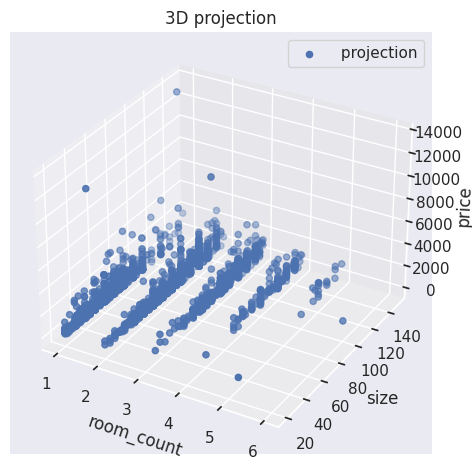

In [ ]:
#espace de projection dim = 3 en 3D: 
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df1["room_count"],df1["size"],df1["price"], label=" projection", color='b')
ax.set_xlabel('room_count')
ax.set_ylabel('size')
ax.set_zlabel('price')
plt.title("3D projection")
plt.legend()
plt.tight_layout()
plt.show()

On fera une classification par K-Means tout d'abord puis Classification hierarchique 

### apply K means on my initial data with K = 10 

On va maintenant appliquer l'analyse hierarchique sur Kmeans 

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df1)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [ ]:
print(df1.shape)
print(labels.shape)

(3648, 4)
(3648,)


In [ ]:
X = df1[['price', 'room_count', 'bathroom_count', 'size']]

# Instantiate a KMeans object with 10 clusters
kmeans = KMeans(n_clusters=8)

# Fit the KMeans object to your data
kmeans.fit(X)

# Get the labels assigned to each data point
labels = kmeans.labels_

# Add the labels to your DataFrame
df1['cluster'] = labels

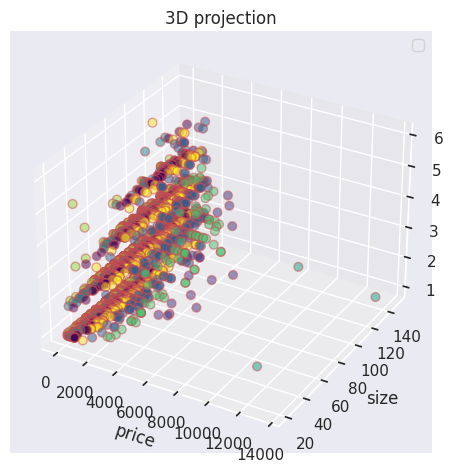

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df1["price"],df1["size"],df1["room_count"],c=labels, cmap='viridis',edgecolor='r', s=40, alpha = 0.5)
centroids_x = centroids1[:,0]
centroids_y = centroids1[:,1]
ax.set_xlabel('price')
ax.set_ylabel('size')
ax.set_zlabel('room_count')
plt.title("3D projection")
plt.legend()
plt.tight_layout()
plt.show()

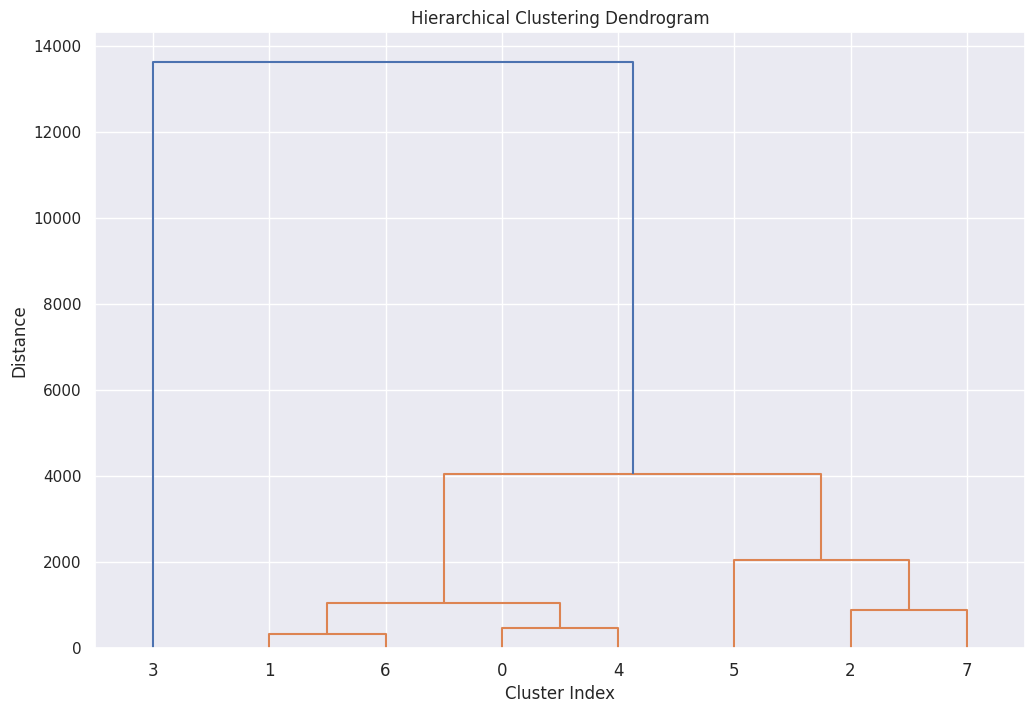

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
#application du HCA sur les centres du K means 
kmeans = KMeans(n_clusters=8, random_state=42).fit(df1[['price', 'room_count', 'bathroom_count', 'size']])

# Retrieve the cluster centers
centers = kmeans.cluster_centers_

# Apply hierarchical clustering on the centers
Z = linkage(centers, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
dendrogram(Z)
plt.show()

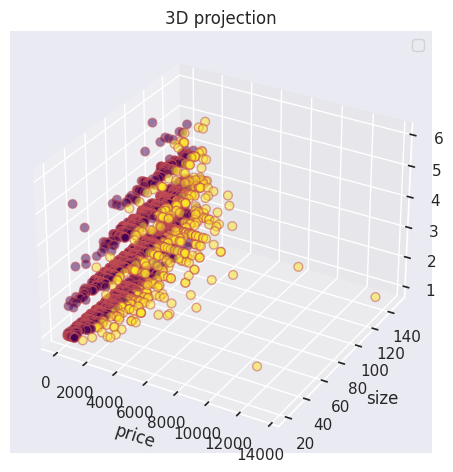

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(df1[['price', 'room_count', 'bathroom_count', 'size']])

# Add the cluster labels to the DataFrame
df1['cluster'] = kmeans.labels_
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(df1["price"],df1["size"],df1["room_count"],c=kmeans.labels_, cmap='viridis',edgecolor='r', s=40, alpha = 0.5)
centroids_x = centroids1[:,0]
centroids_y = centroids1[:,1]
ax.set_xlabel('price')
ax.set_ylabel('size')
ax.set_zlabel('room_count')
plt.title("3D projection")
plt.legend()
plt.tight_layout()
plt.show()

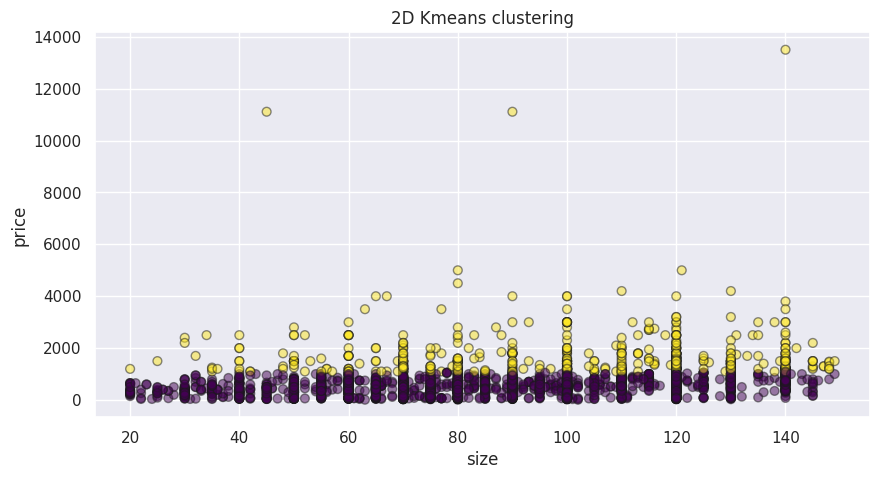

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(df1["size"],df1["price"], c=kmeans.labels_, cmap='viridis',
           edgecolor='k', s=40, alpha = 0.5)

ax.set_title("2D Kmeans clustering")
ax.set_xlabel("size")
ax.set_ylabel("price")   
plt.show()

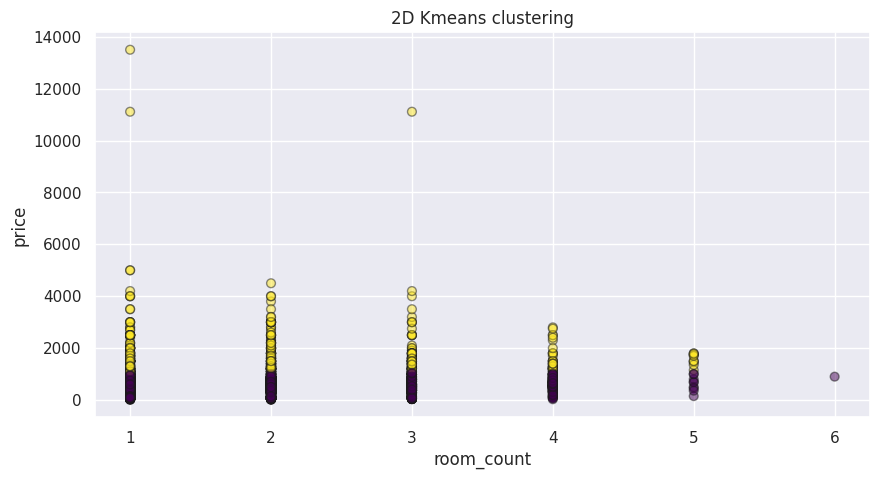

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(df1["room_count"],df1["price"], c=kmeans.labels_, cmap='viridis',
           edgecolor='k', s=40, alpha = 0.5)

ax.set_title("2D Kmeans clustering")
ax.set_xlabel("room_count")
ax.set_ylabel("price")   
plt.show()